# Make daily area means of ICON-NWP TOA radiation fluxes and compare to CERES observations

In [2]:
import numpy as np
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt

import os
import sys

sys.path.append('/pf/b/b380459/nawdex-analysis/')
import dict_nawdexsims

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Set up dask

In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:35045 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 48 Memory: 67.11 GB


## Load auxilliary info for ICON-NWP simulations

In [4]:
simdict   = dict_nawdexsims.simdictionary()
colordict = dict_nawdexsims.colordictionary()

## Load ICON-NWP data into list

In [5]:
def load_iconnwp_data():
    
    ds_list=[]
    
    for sim in list(simdict.keys()):
        
        path = '/work/bb1018/b380459/NAWDEX/ICON_OUTPUT_NWP/'+sim+'/post/'
        start = simdict[sim]['start']
        
        ds = xr.open_mfdataset( path+sim+'_'+start+'00_2drad_30min_alltimesteps.gridr1x1.nc',
                                combine='by_coords', parallel=True, 
                                engine='h5netcdf', chunks={'time': 1} )
        
        ds.attrs['simulation'] = sim
        
        # derive TOA CRE fluxes
        ds['swtoacre'] = (ds['sod_t']-ds['sou_t']) - ds['swtoaclr']
        ds['lwtoacre'] = ds['thb_t'] - ds['lwtoaclr'] 
        
        ds_list.append(ds)
        del ds

    return ds_list

ds_icon_list = load_iconnwp_data()

## Load CERES data into list

Use preprocessed TOA radiation fluxes that were made consistent with ICON.

In [6]:
def load_ceressyn1deg_data():
    
    ds_list=[]
    
    for product in ['Terra-Aqua-MODIS_Ed4A','Terra-NPP_Ed1A']:
        ds = xr.open_dataset('/work/bb1018/b380459/OBS/CERES/CERES_SYN1deg/CERES_SYN1deg-1H_'
                             +product+'_Subset_201609-201610.gridr1x1.derivedTOAfluxes.nc',
                             chunks={'time': 1})
        ds.attrs['simulation'] = 'CERES_'+product
        ds_list.append(ds)

    return ds_list

ds_ceres_list = load_ceressyn1deg_data()

## Restrict ICON and CERES data to common domain defined by boundary zone of 80km simulation

## Calculate area mean over common domain


In [10]:
lat = ds_icon_list[0].lat
lon = ds_icon_list[0].lon

lats=+31; latn=+72; lonw=-64; lone=+25;

In [37]:
weights = np.zeros((lat.size, lon.size)) + np.expand_dims(np.cos(np.deg2rad(lat)), axis=1)
weights = xr.DataArray(weights, coords={'lat':lat, 'lon':lon}, dims=['lat', 'lon'])
weights.name = "weights"

for ds in ds_icon_list+ds_ceres_list:
    for vartemp in ['sod_t','thb_t','sou_t','lwtoacre','lwtoaclr','swtoacre','swtoaclr']:
        for var in [vartemp, vartemp+'_obs', vartemp+'_com']:
            if var not in ds.keys():
                continue
            ds[var+'_areamean'] = ( ds[var].sel(lat=slice(lats,latn), lon=slice(lonw,lone))
                                    .weighted(weights).mean(('lon','lat')) )

## Calculate area mean only over open ocean part of common domain

For this, we first need to read the previously calculated oceanmask for ICON and openoceanmask for CERES and contruct a joint mask.

In [31]:
iconmask  = xr.open_dataarray('/work/bb1018/b380459/NAWDEX/extpar/jointoceanmask_80km-to-2km.gridr1x1.nc')
ceresmask = xr.open_dataarray('/work/bb1018/b380459/OBS/CERES/CERES_SYN1deg/CERES_SYN1deg_201609-201610.gridr1x1.openoceanmask.nc')

mask = xr.ufuncs.minimum(iconmask.rename('mask'),ceresmask.rename('mask'))
mask = mask.fillna(0)

In [36]:
weights = np.zeros((lat.size, lon.size)) + np.expand_dims(np.cos(np.deg2rad(lat)), axis=1) * mask
weights = xr.DataArray(weights, coords={'lat':lat, 'lon':lon}, dims=['lat', 'lon'])
weights.name = "weights"

for ds in ds_icon_list+ds_ceres_list:
    for vartemp in ['sod_t','thb_t','sou_t','lwtoacre','lwtoaclr','swtoacre','swtoaclr']:
        for var in [vartemp, vartemp+'_obs', vartemp+'_com']:
            if var not in ds.keys():
                continue
            ds[var+'_oceanmean'] = ( ds[var].sel(lat=slice(lats,latn), lon=slice(lonw,lone))
                                     .weighted(weights).mean(('lon','lat')) )

In [50]:
def plot_mean(_ds_icon_list, _ds_ceres_list, _var, _meantype):

    plt.figure(figsize=(18,12))
    for ds in _ds_icon_list:
        # make sure that _var is part of dataset
        if _var not in ds.keys():
            continue
        # get plotting color according to resolution
        pcolor=colordict[simdict[ds.attrs['simulation']]['res']]
        # get linestyle according to convection scheme
        conv = simdict[ds.attrs['simulation']]['conv']
        if conv==0:
            lstyle='--'
        elif conv==1:
            lstyle='-'
        elif conv==2:
            lstyle=':'
        # number of days
        ndays=ds[_var+'_'+_meantype].resample(time='1D').mean('time').time.size
        # do not plot first and last day: first day to remove spinup, last day only contains one timestep at 0UTC
        ds[_var+'_'+_meantype].resample(time='1D').mean('time')[1:ndays-1].plot.line(color=pcolor, linestyle=lstyle)

    for ds in _ds_ceres_list:
        if var+_meantype in ds.keys():
            ( ds[var+_meantype].sel(time=slice('2016-09-20','2016-10-17'))
              .resample(time='1D').mean('time').plot.line(color='k', linestyle=':') )
        if _var+'_com_'+_meantype in ds.keys():
            ( ds[_var+'_com_'+_meantype].sel(time=slice('2016-09-20','2016-10-17'))
              .resample(time='1D').mean('time').plot.line(color='k', linestyle='-') )
        if _var+'_obs_'+_meantype in ds.keys():
            ( ds[_var+'_obs_'+_meantype].sel(time=slice('2016-09-20','2016-10-17'))
              .resample(time='1D').mean('time').plot.line(color='k', linestyle='--') )

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

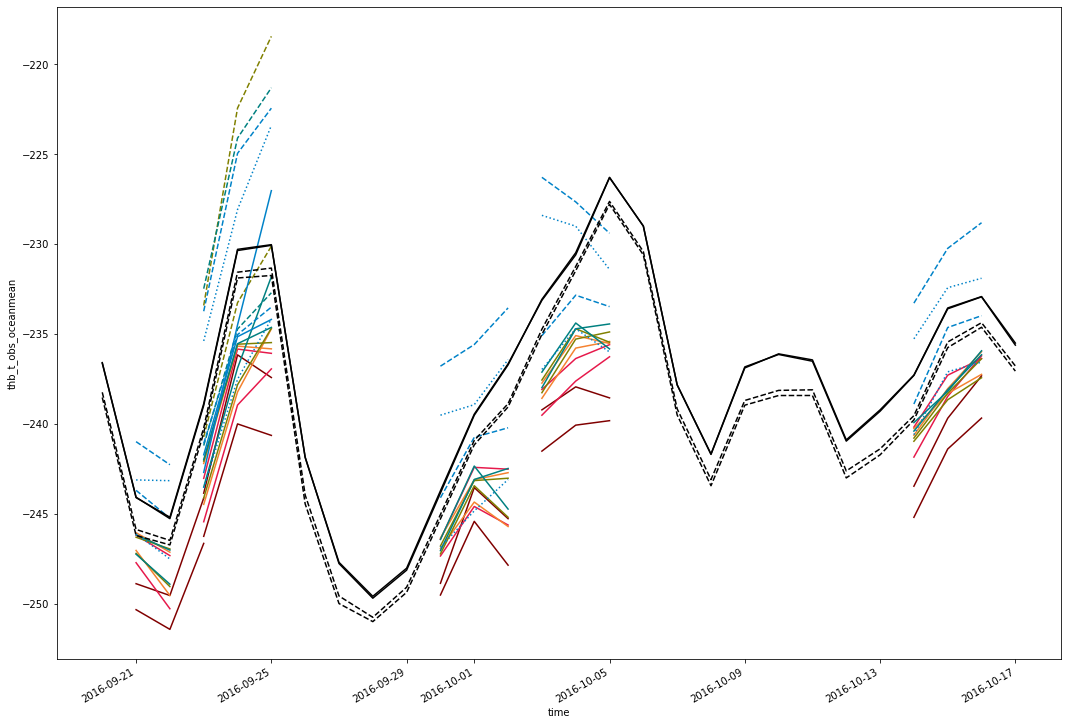

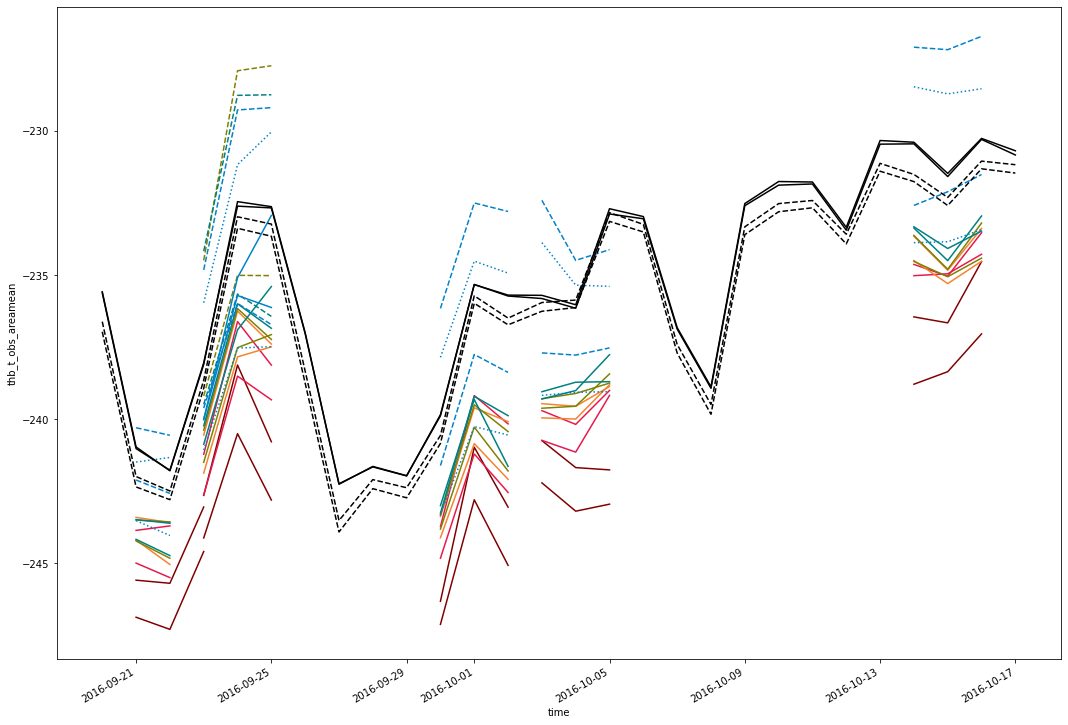

In [51]:
for var in ['thb_t']: #,'sou_t','sod_t','lwtoacre','lwtoaclr','swtoacre','swtoaclr']:
    plot_mean(ds_icon_list, ds_ceres_list, var, 'oceanmean')
    plot_mean(ds_icon_list, ds_ceres_list, var, 'areamean')